In [317]:
import pandas as pd
import numpy as np
import patsy
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report

In [318]:
df = pd.read_csv('./data/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [319]:
df.odor.value_counts().sum()

8124

In [320]:
df[df.odor=='m']['class'].value_counts()

p    36
Name: class, dtype: int64

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Text(0.5,1,'Edible or Poisonous by Smell')

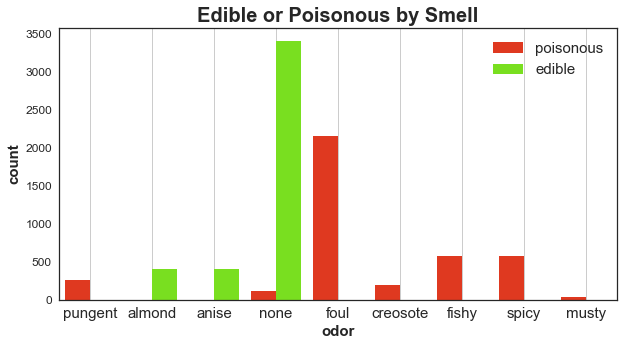

In [321]:
sns.set_style("white")
sns.set_context({"figure.figsize": (10, 5)})
data = df[['odor','class']]
odor_dict = {'a': 'almond',
             'l':'anise',
             'c':'creosote',
             'y':'fishy',
             'f':'foul', 
             'm':'musty',
             'n':'none',
             'p':'pungent',
             's':'spicy'}
data['odor'] = data.odor.map(odor_dict)
ax = sns.countplot(palette=['#FF2200','#77FF00'], x="odor", hue="class", data=data, orient='h')
plt.legend(['poisonous','edible'],fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel('odor',fontsize=15,fontweight='bold')
plt.ylabel('count',fontsize=15,fontweight='bold')
ax.xaxis.grid()
plt.title('Edible or Poisonous by Smell', fontsize=20, fontweight='bold')

Text(0.5,1,'No smell, by spore-print-color')

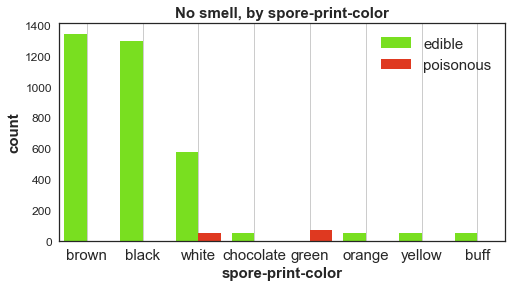

In [322]:
attrib = 'spore-print-color'
sns.set_style("white")
sns.set_context({"figure.figsize": (8, 4)})
data = df[df.odor=='n'][[attrib,'class']]
spore_dict = {'k':'black',
              'n':'brown',
              'b':'buff',
              'h':'chocolate',
              'r':'green', 
              'o':'orange',
              'u':'purple',
              'w':'white',
              'y':'yellow'}
data[attrib] = data[attrib].map(spore_dict)
ax = sns.countplot(palette=['#77FF00','#FF2200'], x=attrib, hue="class", data=data)
plt.legend(['edible','poisonous'],fontsize=15,loc='upper right')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel(attrib,fontsize=15,fontweight='bold')
plt.ylabel('count',fontsize=15,fontweight='bold')
ax.xaxis.grid()
plt.title('No smell, by '+attrib, fontsize=15, fontweight='bold')

In [323]:
data['class'].value_counts()

e    3408
p     120
Name: class, dtype: int64

In [324]:
for col in df.columns:
    print(col)

class
cap-shape
cap-surface
cap-color
bruises
odor
gill-attachment
gill-spacing
gill-size
gill-color
stalk-shape
stalk-root
stalk-surface-above-ring
stalk-surface-below-ring
stalk-color-above-ring
stalk-color-below-ring
veil-type
veil-color
ring-number
ring-type
spore-print-color
population
habitat


In [325]:
df = pd.read_pickle('./data/mushrooms_alldummies.pkl')

df = df.drop(['cap-shape_bell',
              'cap-shape_conical',
              'cap-shape_flat',
              'cap-shape_knobbed',
              'cap-shape_sunken',
              'cap-shape_convex'], axis=1)

df['cap-color_yellow'] = df['cap-color_yellow'] + df['cap-color_buff']
df['cap-color_brown'] = df['cap-color_brown'] + df['cap-color_cinnamon']
df = df.drop(['cap-color_buff','cap-color_cinnamon'], axis=1)

df = df.drop(['bruises_no'],axis=1)

df = df.drop(['odor_foul','odor_pungent','odor_fishy','odor_spicy','odor_musty','odor_creosote','odor_anise'],axis=1)

df = df.drop(['gill-attachment_free'], axis=1)
df = df.drop(['gill-spacing_close'], axis=1)

df = df.drop(['gill-size_broad','gill-size_narrow'], axis=1)

df['gill-color_yellow'] = df['gill-color_yellow'] + df['gill-color_buff']
df['gill-color_brown'] = df['gill-color_brown'] + df['gill-color_chocolate']
df = df.drop(['gill-color_buff','gill-color_chocolate'], axis=1)

df = df.drop(['stalk-shape_enlarging','stalk-shape_tapering'],axis=1)
df = df.drop(['stalk-root_missing','stalk-root_bulbous','stalk-root_club','stalk-root_equal','stalk-root_rooted'],axis=1)

df['stalk-color-above-ring_brown'] = df['stalk-color-above-ring_brown'] + df['stalk-color-above-ring_cinnamon']
df['stalk-color-above-ring_yellow'] = df['stalk-color-above-ring_yellow'] + df['stalk-color-above-ring_buff']
df = df.drop(['stalk-color-above-ring_cinnamon','stalk-color-above-ring_buff'], axis=1)

df['stalk-color-below-ring_brown'] = df['stalk-color-below-ring_brown'] + df['stalk-color-below-ring_cinnamon']
df['stalk-color-below-ring_yellow'] = df['stalk-color-below-ring_yellow'] + df['stalk-color-below-ring_buff']
df = df.drop(['stalk-color-below-ring_cinnamon','stalk-color-below-ring_buff'], axis=1)

df = df.drop(['veil-type_partial','veil-color_brown','veil-color_orange','veil-color_white','veil-color_yellow'],axis=1)

df = df.drop(['ring-number_none'], axis=1)

df = df.drop(['ring-type_evanescent','ring-type_flaring','ring-type_large','ring-type_none','ring-type_pendant'],axis=1)

df['stalk-surface-below-ring_smooth'] = df['stalk-surface-below-ring_smooth'] + df['stalk-surface-below-ring_silky']
df['stalk-surface-above-ring_smooth'] = df['stalk-surface-above-ring_smooth'] + df['stalk-surface-above-ring_silky']
df = df.drop(['stalk-surface-below-ring_silky','stalk-surface-above-ring_silky'], axis=1)

df['spore-print-color_yellow'] = df['spore-print-color_yellow'] + df['spore-print-color_buff']
df['spore-print-color_brown'] = df['spore-print-color_brown'] + df['spore-print-color_chocolate']
df = df.drop(['spore-print-color_buff','spore-print-color_chocolate'],axis=1)

df = df.drop(['population_abundant','population_numerous','population_scattered','population_several'],axis=1)

df['habitat_grasses'] = df['habitat_grasses'] + df['habitat_meadows']
df = df.drop(['habitat_meadows','habitat_paths','habitat_urban','habitat_waste'],axis=1)

for col in df.columns:
    print(col)

poisonous
cap-surface_fibrous
cap-surface_grooves
cap-surface_smooth
cap-surface_scaly
cap-color_red
cap-color_gray
cap-color_brown
cap-color_pink
cap-color_green
cap-color_purple
cap-color_white
cap-color_yellow
bruises_yes
odor_almond
odor_none
gill-attachment_attached
gill-spacing_crowded
gill-color_red
gill-color_gray
gill-color_black
gill-color_brown
gill-color_orange
gill-color_pink
gill-color_green
gill-color_purple
gill-color_white
gill-color_yellow
stalk-surface-above-ring_fibrous
stalk-surface-above-ring_smooth
stalk-surface-above-ring_scaly
stalk-surface-below-ring_fibrous
stalk-surface-below-ring_smooth
stalk-surface-below-ring_scaly
stalk-color-above-ring_red
stalk-color-above-ring_gray
stalk-color-above-ring_brown
stalk-color-above-ring_orange
stalk-color-above-ring_pink
stalk-color-above-ring_white
stalk-color-above-ring_yellow
stalk-color-below-ring_red
stalk-color-below-ring_gray
stalk-color-below-ring_brown
stalk-color-below-ring_orange
stalk-color-below-ring_pink
sta

In [329]:
data = df#df[df['odor_none']==1]
X = data.iloc[:,1:]
y = data.iloc[:,0]
# np.random.seed(seed=333)
# def add_noise(val):
#     if np.random.random()>0.8:
#         return 1-val
#     else:
#         return val
# X = X.applymap(add_noise)

# X = X.drop(['odor_none','odor_almond'],axis=1)
X = X.drop(['spore-print-color_black',
            'spore-print-color_brown',
            'spore-print-color_orange',
            'spore-print-color_green',
            'spore-print-color_purple',
            'spore-print-color_white',
            'spore-print-color_yellow'],axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=0.3, random_state=432)

data.shape

(8124, 62)

### Decision Tree

Training Data Accuracy: 0.97
             precision    recall  f1-score   support

          0       0.96      0.97      0.97      2945
          1       0.97      0.96      0.96      2741

avg / total       0.97      0.97      0.97      5686

[[2634  107]
 [  86 2859]]
Test Data Accuracy:     0.96
             precision    recall  f1-score   support

          0       0.96      0.97      0.96      1263
          1       0.97      0.95      0.96      1175

avg / total       0.96      0.96      0.96      2438

[[1118   57]
 [  34 1229]]
Training Data Accuracy: 0.97
             precision    recall  f1-score   support

          0       0.96      0.97      0.97      2945
          1       0.97      0.96      0.96      2741

avg / total       0.97      0.97      0.97      5686

[[2634  107]
 [  86 2859]]
Test Data Accuracy:     0.97
             precision    recall  f1-score   support

          0       0.96      0.97      0.97      2945
          1       0.97      0.96      0.96      274

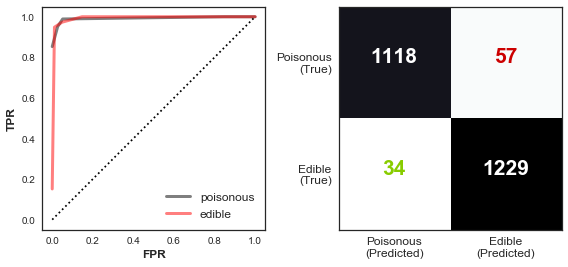

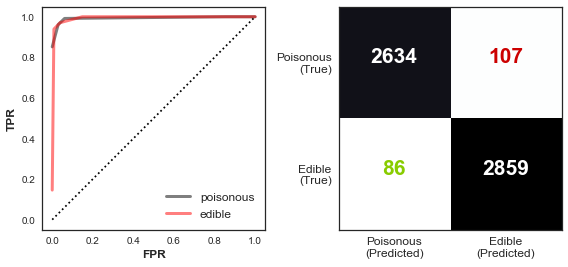

In [330]:
dt = DecisionTreeClassifier(max_depth=5,class_weight='balanced')
model_scores(dt, xtrain, ytrain, xtest, ytest, threshold)
model_scores(dt, xtrain, ytrain, xtrain, ytrain, threshold)

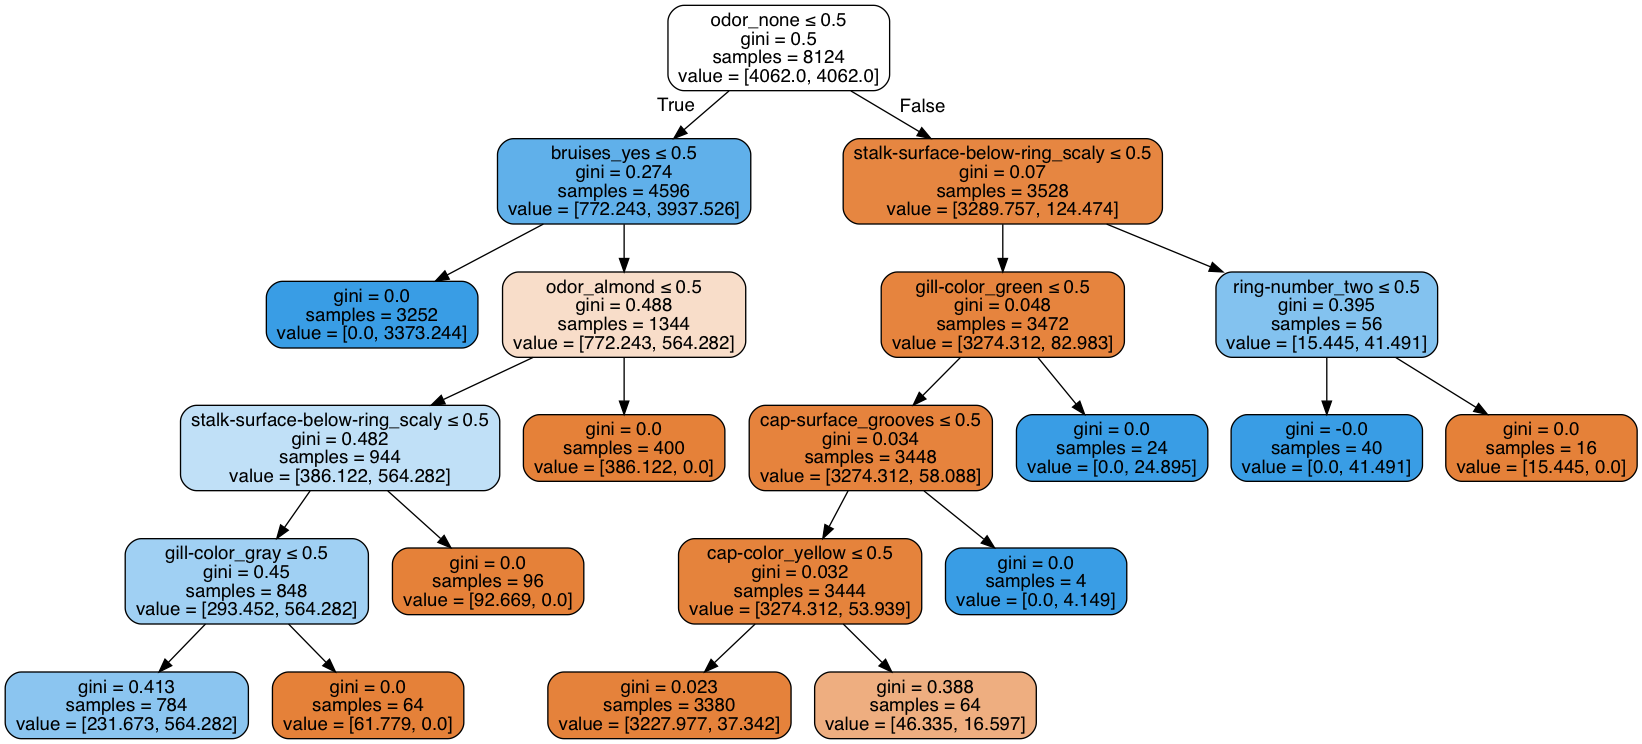

In [331]:
dot_data = StringIO()
dt.fit(X,y)
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [240]:
def tree2json(decision_tree, out_file=None, feature_names=None):
    
    import numpy as np
    from sklearn.tree import _tree

    def arr_to_py(arr):
        arr = arr.ravel()
        wrapper = float
        if np.issubdtype(arr.dtype, np.int):
            wrapper = int
        return map(wrapper, arr.tolist())


    def node_to_str(tree, node_id):
        if (tree.children_left[node_id] == tree.children_right[node_id]): # is leaf
            if tree.value[node_id].argmax()==0:
                node_repr = '"name": "--> Low risk"'
            else:
                node_repr = '"name": "--> High risk"'
            print("Is a leaf",node_repr)
        else: # not leaf
            node_repr = '"name": "%s"' \
                    % (feature_names[tree.feature[node_id]])
            print("Not a leaf",node_repr)
        return node_repr

    def recurse(tree, node_id, parent=None):

        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]
        print(node_id,left_child,right_child)

        # Open node with description
        out_file.write('{%s' % node_to_str(tree, node_id))

        # write children
        if left_child != right_child: # not leaf
            out_file.write(', "children": [')
            recurse(tree, left_child, node_id)
            out_file.write(', ')
            recurse(tree, right_child, node_id)
            out_file.write(']')

        # close node
        out_file.write('}')

    if out_file is None:
        out_file = open("tree.json", "w")
    else:
        out_file = open(out_file, "w")

    if isinstance(decision_tree, _tree.Tree):
        recurse(decision_tree, 0)
    else:
        print('getting tree structure')
        recurse(decision_tree.tree_, 0)

    return out_file

In [281]:
out_file = tree2json(dt, out_file="temp.json",feature_names=X.columns)
out_file.close()

getting tree structure
0 1 18
Not a leaf "name": "stalk-surface-above-ring_silky"
1 2 15
Not a leaf "name": "gill-color_yellow"
2 3 8
Not a leaf "name": "cap-surface_smooth"
3 4 7
Not a leaf "name": "spore-print-color_green"
4 5 6
Not a leaf "name": "cap-color_white"
5 -1 -1
Is a leaf "name": "--> Low risk"
6 -1 -1
Is a leaf "name": "--> Low risk"
7 -1 -1
Is a leaf "name": "--> High risk"
8 9 12
Not a leaf "name": "gill-spacing_crowded"
9 10 11
Not a leaf "name": "stalk-color-above-ring_white"
10 -1 -1
Is a leaf "name": "--> Low risk"
11 -1 -1
Is a leaf "name": "--> High risk"
12 13 14
Not a leaf "name": "habitat_woods"
13 -1 -1
Is a leaf "name": "--> Low risk"
14 -1 -1
Is a leaf "name": "--> High risk"
15 16 17
Not a leaf "name": "spore-print-color_white"
16 -1 -1
Is a leaf "name": "--> Low risk"
17 -1 -1
Is a leaf "name": "--> High risk"
18 19 20
Not a leaf "name": "ring-number_two"
19 -1 -1
Is a leaf "name": "--> High risk"
20 -1 -1
Is a leaf "name": "--> Low risk"
